# Class 12

## April. 2, 2024

By the end of this class, you'll be able to:

- Conduct spatial clustering analysis


# Review of clustering

## What is clustering? 

Clustering, generally, is the act of grouping similar things with eachother.

We can do this with non-spatial data as well as spatial data. 

One common clustering method is k-means, which we won't cover in this class, but if you're interested, there's a nice tutorial on the method here: 

https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203


### Spatial clustering, at a high level, is doing the same thing but one attribute to consider is geography. 

Spatial clustering involves looking at:

- how some attribute is expressed across space; 

- whether similar attribute values are near each other. 


## Autocorrelation

Autocorrelation literally means 'self correlations'. 

So instead of looking at how two attributes relate to each other (e.g., regression), we want to explore one a single attribute relates to its neighbours.

Typically, we're talking about temporal autocorrelation or spatial autocorrelation.

## Spatial Autocorrelation

How does a variable value in a specific location correlate with the variable values in its neighbours?

- regress a value on the values of its neighbours!


### 1) For each observation (in this case, neighborhood) we need to know their neighbours!

To do this we can create something known as a 'weights matrix'.

A weights matrix is a matrix that describes whether or not any one observation is 'neighbours' with another.

There are many ways we can do this, but let's focus on two common ones: queen's contiguity matrix and the rook's contiguity matrix:

Queen's contiguity matrix define the neighbors as either shared edges or nodes, while rook's contiguity defines the neighbors as shared edges

![weights matrices](https://i.stack.imgur.com/CWIHi.jpg)

Think about: why the weights matrix can represent contiguity of neighbourhoods?

### 2) Next we need to describe the value of our attribute of interest in neighbours

To do this we create a variable known as 'spatial lag'. 

Spatial lag for neighbourhood *i* is often just the average of some attribute value across all of neighbourhood *i*'s neighbours (as determined by our weights matrix!).

### 3) Finally, now we can see how a neighbourhood's attribute compares to its neighbours. 

This set up allows us to see if neighbourhood's with high attribute values are next to other neighbourhoods with high values. 

We can then use a number of statistical tests to determine if there are 'significant' clusters in our dataset. 


# Conducting spaital clusering analysis 

Let's see if we have spatial clusters in:
1. the percent of adults with asthma in Toronto
2. a random column of numbers


### Step 1: import and merge DataFrame with Toronto's GeoDataFrame

We have done this so many times! Let's do it one more time.

In [1]:
# Import packages
import geopandas as gpd
import pandas as pd

In [2]:
# Import and clean neighborhood geodata

nbrhd = gpd.GeoDataFrame.from_file("Toronto_Neighbourhoods.geojson")
important_spat_cols = nbrhd.columns[[4, 5, 17]]
colnames_spat = {important_spat_cols[0]: 'name',
           important_spat_cols[1] : 'nbrhd_spat_id',
           important_spat_cols[2] : 'geometry'}
nbrhd_simple = nbrhd.copy()
nbrhd_simple = nbrhd_simple[important_spat_cols]
nbrhd_simple.rename(columns = colnames_spat, inplace=True)

# remember to change the data type of neighbor id
nbrhd_simple["Neighbid"] = nbrhd_simple["nbrhd_spat_id"].astype(int) 
nbrhd_simple.head()

,name,nbrhd_spat_id,geometry,Neighbid
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96
1,Annex (95),095,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",95
2,Caledonia-Fairbank (109),109,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",109
3,Woodbine Corridor (64),064,"POLYGON ((-79.31485 43.66674, -79.31660 43.666...",64
4,Lawrence Park South (103),103,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",103


In [3]:
# Import and clean asthma data
fname = '1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls'
sname = '1_ahd_neighb_asthma_2007'
asthma_neighb = pd.read_excel(fname, sheet_name = sname, header = 11)
important_cols = asthma_neighb.columns[[0, 1, 10, 11]] 
colnames = {important_cols[0] : 'Neighbid', 
            important_cols[1] : 'name', 
            important_cols[2] : 'adult_pop',
            important_cols[3] : 'asthma_pct'}
asthma_rates = asthma_neighb.copy()
asthma_rates = asthma_rates[important_cols]
asthma_rates.rename(columns = colnames, inplace=True)
asthma_rates.head()

,Neighbid,name,adult_pop,asthma_pct
0,1,West Humber-Clairville,23747,10.2
1,2,Mount Olive-Silverstone-Jamestown,22619,9.1
2,3,Thistletown-Beaumond Heights,6629,10.0
3,4,Rexdale-Kipling,6755,11.4
4,5,Elms-Old Rexdale,6588,11.6


In [4]:
# Merge the DataFrame to GeoDataFrame
nbrhd_simple = nbrhd_simple.merge(asthma_rates, on="Neighbid")

Before we start doing cluster analysis, we create a column of random numbers to our neighbor GeoDataFrame

This is to generate a *random spatial pattern* in our Toronto dataset.

We **shouldn't** expect any spatial clusters in this random data

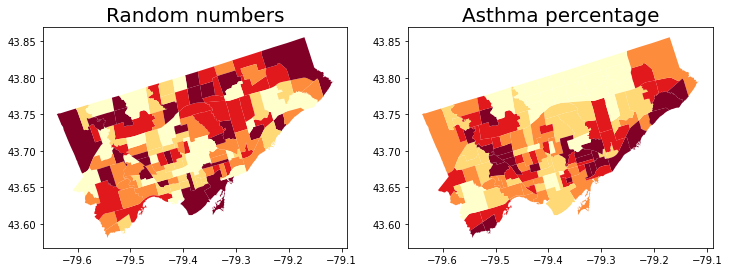

In [5]:
import numpy as np
import matplotlib.pyplot as plt

nbrhd_simple['randNumCol'] = np.random.randint(1, 101, nbrhd_simple.shape[0])

fig, axes = plt.subplots(1, 2, figsize = (12,12))
nbrhd_simple.plot(column = "randNumCol", cmap = 'YlOrRd', scheme='quantiles', k=5, ax=axes[0])
nbrhd_simple.plot(column = "asthma_pct", scheme='quantiles', k=5, cmap = 'YlOrRd', ax=axes[1])
axes[0].set_title("Random numbers", fontsize = 20)
axes[1].set_title("Asthma percentage", fontsize = 20);

### Step 2: Identify the neighbours

We will use the package [`libpysal`](https://pysal.org/libpysal/) to complete this task.

The neighbours of neighbourhoods are also knowns as "weight matrix".

We will use the Queen's contiguity weight.

Before creating weight matrix, we need to project the gdf into a projection coordinate system (e.g., Web Mercator). We will not cover it in detail in this class.

/var/folders/p0/ynn6kljd5pg6sh4_616yzw3c0000gn/T/ipykernel_1419/3094296792.py:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(nbrhd_simple)


(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

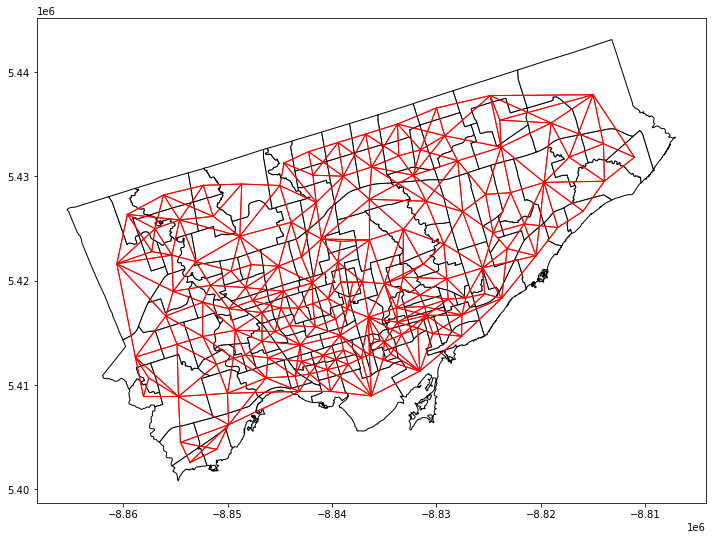

In [6]:
import libpysal as lps
# Reproject the gdf to 'Web Mercator'
nbrhd_simple = nbrhd_simple.to_crs("EPSG:3857")

# Create the spatial weights matrix
w = lps.weights.Queen.from_dataframe(nbrhd_simple)

fig, axes = plt.subplots(1,1, figsize = (12,12))
# add nbrhd map
nbrhd_simple.plot(ax = axes, edgecolor = 'black', facecolor = 'w')
# show what weights look like
w.plot(nbrhd_simple, ax=axes, 
        edge_kws=dict(color='r', linewidth=1),
        node_kws=dict(marker=''))

### Let's inspect the weights matrix further. What does it look like: 

The first neighborhood has 5 neighbours: 128, 1, 133, 134, and 55

(And the weight of each neighbour is 1)

In [7]:
w[0] 

{128: 1.0, 1: 1.0, 133: 1.0, 134: 1.0, 55: 1.0}

In [8]:
nbrhd_simple['name_y'][[0,128,1,133,134,55]]

0               Casa Loma
128     Forest Hill South
1                   Annex
133              Wychwood
134       Yonge-St. Clair
55     Humewood-Cedarvale
Name: name_y, dtype: object

In [9]:
first_neighborhood = nbrhd_simple.loc[[0]]
first_neighbors = nbrhd_simple.loc[[128,1,133,134,55]]

<AxesSubplot:>

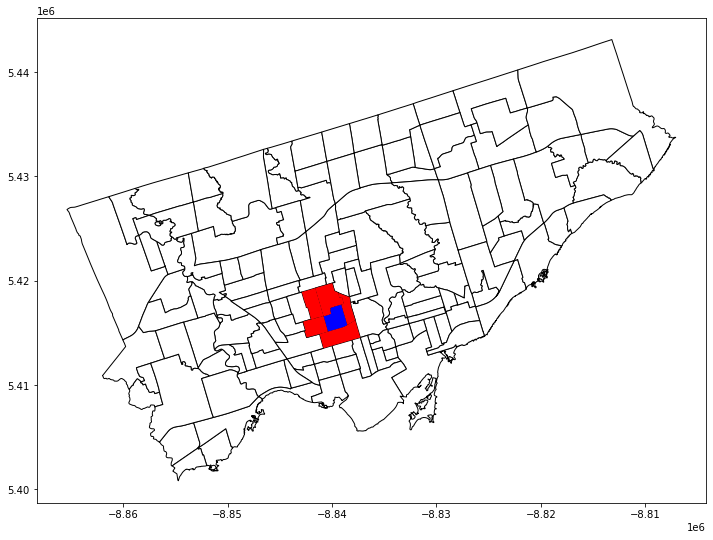

In [10]:
fig, axes = plt.subplots(1,1, figsize = (12,12))
nbrhd_simple.plot(ax = axes, edgecolor = 'black', facecolor = 'w')
first_neighborhood.plot(ax=axes, facecolor = 'b')
first_neighbors.plot(ax = axes, facecolor='r')

let's see if 128 is also connected to 0

In [11]:
w[128]

{0: 1.0, 16: 1.0, 4: 1.0, 134: 1.0, 55: 1.0, 62: 1.0}

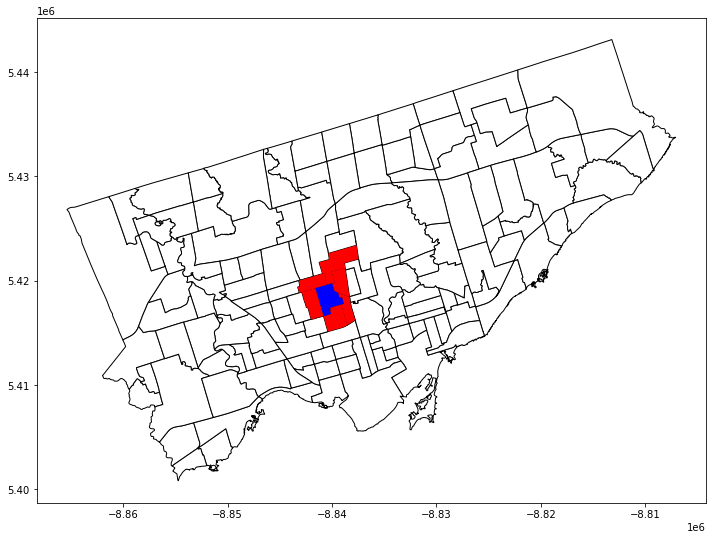

In [12]:
target_neighborhood = nbrhd_simple.loc[[128]]
target_neighbors = nbrhd_simple.loc[[0,16,4,134,55,62]]

fig, axes = plt.subplots(1,1, figsize = (12,12))
nbrhd_simple.plot(ax = axes, edgecolor = 'black', facecolor = 'w')
target_neighborhood.plot(ax=axes, facecolor = 'b')
target_neighbors.plot(ax = axes, facecolor='r');

We can also look at the distribution of connections using the built in weights histogram function.

The first number is the count of connections and the second number is the number of neighbourhoods with this count of connections. 

For example, there are 9 neighbourhoods with 3 connections, 13 with 4 connections, etc.

In [13]:
w.histogram

[(3, 9), (4, 13), (5, 31), (6, 40), (7, 25), (8, 13), (9, 8), (10, 0), (11, 1)]

Finally let's 'row standardize' our matrix so that each nbrhd's connections sum to one:

In [14]:
# Row standardize the matrix
w.transform = 'R'

#how did this change things?
print('weights for nbrhd 0: ', w[0])
print('weights for nbrhd 128: ', w[128])

weights for nbrhd 0:  {128: 0.2, 1: 0.2, 133: 0.2, 134: 0.2, 55: 0.2}
weights for nbrhd 128:  {0: 0.16666666666666666, 16: 0.16666666666666666, 4: 0.16666666666666666, 134: 0.16666666666666666, 55: 0.16666666666666666, 62: 0.16666666666666666}


### Step 3: Now that we have spatial weights established, we can calculate the average value of the neighbours of each neighbourhood, aka spatial lag.

Let's do that for the asthma percentage `asthma_pct` and for the random numbers `randNumCol`

In [15]:
# calculate the average of asthma_pct attribute of neighbours, then store in a new column

nbrhd_simple['w_asthma_pct'] = lps.weights.lag_spatial(w, nbrhd_simple['asthma_pct'])
nbrhd_simple.head()

,name_x,nbrhd_spat_id,geometry,Neighbid,name_y,adult_pop,asthma_pct,randNumCol,w_asthma_pct
0,Casa Loma (96),096,"POLYGON ((-8840403.206 5415116.967, -8840420.5...",96,Casa Loma,6640,10.1,25,10.480000
1,Annex (95),095,"POLYGON ((-8838115.394 5414318.191, -8838308.4...",95,Annex,20869,9.5,9,9.788889
2,Caledonia-Fairbank (109),109,"POLYGON ((-8845470.121 5416294.143, -8845495.7...",109,Caledonia-Fairbank,6615,11.3,18,11.150000
3,Woodbine Corridor (64),064,"POLYGON ((-8829288.812 5414013.407, -8829483.7...",64,Woodbine Corridor,8346,13.0,62,11.825000
4,Lawrence Park South (103),103,"POLYGON ((-8839987.390 5419761.937, -8840063.9...",103,Lawrence Park South,9709,10.7,36,10.200000


Let's look at a scatter plot between asthma_pct in each neighbourhood vs. the avg asthma_pct in their neighbors.

Recall our scatter plot in the regression class.

Keep in mind: we say spatial clustering is a kind of spatial autocorrelation, so the independent variable (x) is the target variable, while the dependent variable (y) is its *spatial lag*.

What relationships can you identify from the plot?

<AxesSubplot:xlabel='asthma_pct', ylabel='w_asthma_pct'>

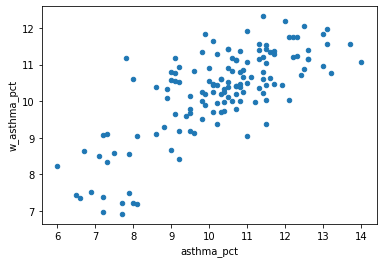

In [16]:
nbrhd_simple.plot.scatter(x = "asthma_pct", y = "w_asthma_pct")

Let's repeat the above, but for our random number column we created.

<AxesSubplot:xlabel='randNumCol', ylabel='w_randNumCol'>

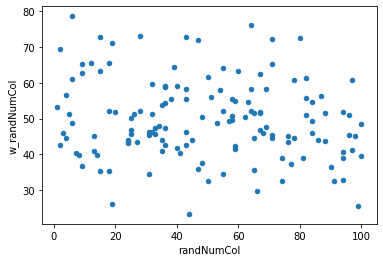

In [17]:
nbrhd_simple['w_randNumCol'] = lps.weights.lag_spatial(w, nbrhd_simple['randNumCol'])
nbrhd_simple.plot.scatter(x = "randNumCol", y = "w_randNumCol")

## So what do we see in the above two scatterplots?

- As `asthma_pct` in a specific neighbourhood gets larger, the average value of `asthma_pct` in that neighbhourhood's neighbours *(gets smaller/gets bigger/doesn't change)*.
 
- As `randNumCol` in a specific neighbourhood gets larger, the average value of `randNumCol` in that neighbhourhood's neighbours *(gets smaller/gets bigger/doesn't change)*.

<AxesSubplot:xlabel='randNumCol', ylabel='w_randNumCol'>

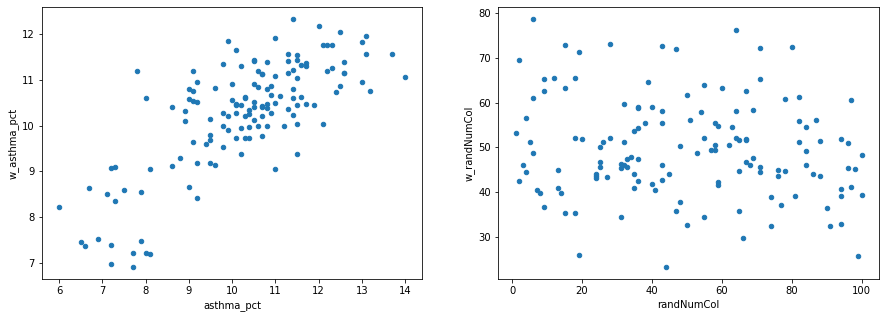

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
nbrhd_simple.plot.scatter(x = "asthma_pct", y = "w_asthma_pct", ax=axes[0])
nbrhd_simple.plot.scatter(x = "randNumCol", y = "w_randNumCol", ax=axes[1])

### Step 4: Using a unique indicator to test the spatial autocorrelation

## Moran's I
Moran's I is global spatial autocorrelation statistic that tells us if high values are next to high values and low values are next to low values. 

There is also a way to determine if this occurs at a significan level - e.g., does this sorting happen more than expected if the values were randomly spread across our study area.

The value of Moran's I ranges from -1 to 1, where I of 1 is perfectly clustered and -1 is perfectly 'dispersed' (clustered and dispersed are two typical spatial patterns)

![example of morans I](https://static.cambridge.org/binary/version/id/urn:cambridge.org:id:binary:20200421144010724-0711:9781108614528:49898fig4_1.png)

**Ho (null hypothesis) = the values of asthma_pct are randomly distributed across our study area**

**Ha (alternative hypothesis) = the values of asthma_pct are not randomly distributed** 

If our p value is < 0.05 we will reject our null hypothesis Ho

We will use a new package `esda` ["Exploratory Spatial Data Analysis"](https://pysal.org/esda/) to calculate Moran's I.

Another package [`splot`](https://splot.readthedocs.io/en/latest/) is to visualize the output.

The pacakage automatically calculate the spaital lag using our spatial weight matrix `w`.

You can also find more inforamtion of Moran's I [here](https://en.wikipedia.org/wiki/Moran%27s_I). Roughly speaking, Moran's I is a weighted autocorrelation statstic.

You can also relate the process to do a regression between the targe variable and its spatial lags, while the Moran's I is like the correlation coefficient (but not exactly the same!)

Let's firstly try regressing the spatial lag `w_asthma_pct` on the attribute `asthma_pct`.

The coefficient is significant, indicating a high possibility of significant Moran's I!

In addition, the coefficient is >0, indicating that a high value is potentially surrounding by high value, vice versa. 

In [19]:
from statsmodels.formula.api import ols
reg = ols('w_asthma_pct ~ asthma_pct', data = nbrhd_simple).fit()
reg_sum = reg.summary()
reg_sum.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.6343,0.424,10.925,0.000,3.796,5.473
asthma_pct,0.5479,0.041,13.408,0.000,0.467,0.629


The Morans I value is:  0.5478579432852013
The p-value of this Morans I value is:  0.001


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (0.55)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

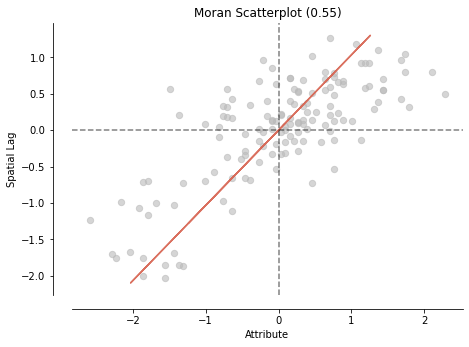

In [20]:
import esda
import splot
from splot.esda import moran_scatterplot

mi = esda.Moran(nbrhd_simple['asthma_pct'], w)

print('The Morans I value is: ', mi.I)
print('The p-value of this Morans I value is: ', mi.p_sim)

#visualize!
splot.esda.moran_scatterplot(mi)

The Moran's plot shows us the same scatter we saw before except now they've standardized the variable value and the spatial lag values (aka made them z-scores, where 0 is average). 


We can furtherly break the scatterplot into 4 quadrants - going counter clockwise, starting from the upper-right. 

1. The upper right is the 'high-high' quadrant, where high values in a nbrhd are next to neighbours with high values (quadrant 1)
2. The upper left is the 'low-high' quadrant, where low values in a nbrhd are next to neighbours with high values (quadrant 2)
3. The lower left is the 'low-low' quadrant (quadrant 3)
4. The lower right is the 'high-low' quadrant (quadrant 4)


If most points in our scatterplot are in the high-high and low-low quadrants we probably have clustering. 

If they are mostly in the low-high and high-low then there's likely dispersal. 

If there is no obvious pattern, then there's no sptial pattern - random distributed!

### Let's do it again with the random numbers column

The Morans I value is:  -0.05838857919204233
The p-value of this Morans I value is:  0.16


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (-0.06)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

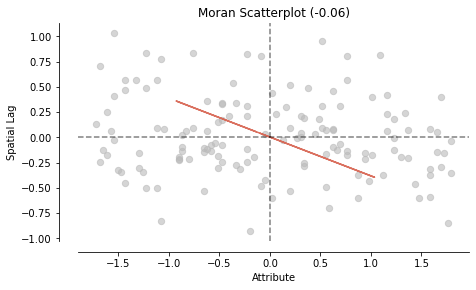

In [21]:
mi_randNumCol = esda.Moran(nbrhd_simple['randNumCol'], w)

print('The Morans I value is: ', mi_randNumCol.I)
print('The p-value of this Morans I value is: ', mi_randNumCol.p_sim)

#visualize!
splot.esda.moran_scatterplot(mi_randNumCol)

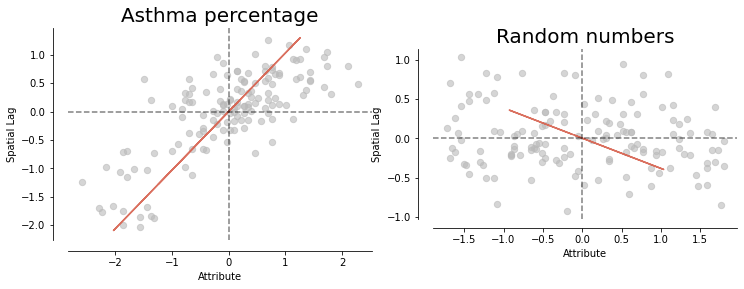

In [22]:
# Make the comparison
fig, axes = plt.subplots(1,2, figsize = (12,12))
splot.esda.moran_scatterplot(mi, ax=axes[0])
splot.esda.moran_scatterplot(mi_randNumCol, ax=axes[1])

axes[0].set_title("Asthma percentage", fontsize = 20)
axes[1].set_title("Random numbers", fontsize = 20);

## Local Spatial Autocorrelation

### Step 5: identify the clusters

When Moran's I is significant (i.e., <0.05), we can say there is a significant spatial autocorrelation for the variable.

More specifically, we can say there is a pattern of spatial clustering (Moran's I significant and >0) of asthma percentage in Toronto neighborhooods!

**But WHERE are the clusters?**

We can use a different statistic to identify significant incidents of the clusters, i.e., **local indicators of spatial autocorrelation (LISA)**. 

This tells us exactly where on the map this clustering is happening!

We can think about the Moran's I plots to help us here. 

Using a new function we can identify which quadrant each neighbourhood is in, and if the relationship to neighbourhing values is strong enough to be significant. 

For our case, those observations in quadrant 1 and 3 are 'clustered' and those in 2 and 4 would be 'outliers'. 

The Morans I value is:  0.5478579432852013
The p-value of this Morans I value is:  0.001


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (0.55)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

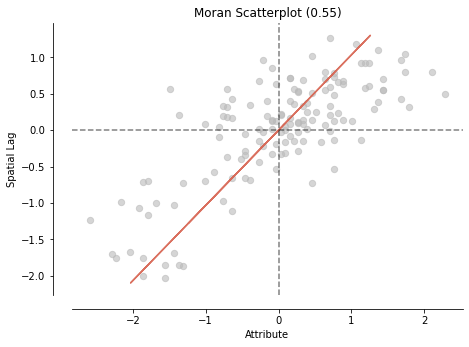

In [23]:
print('The Morans I value is: ', mi.I)
print('The p-value of this Morans I value is: ', mi.p_sim)
splot.esda.moran_scatterplot(mi)

The `Moran_Local` function help us to generate a statistic for each neighbourhood.

We want to name the reult as `lisa`, because lisa (local indicators of spatial association).

In [24]:
lisa = esda.Moran_Local(nbrhd_simple['asthma_pct'], w)

It has two attributes: `.p_sim` store the significace, `.q` store which quadrant the neighbourhoods belong to

In [27]:
# Break observations into significant or not
nbrhd_simple['significant'] = (lisa.p_sim < 0.05)

# Store the quadrant they belong to
nbrhd_simple['quadrant'] = lisa.q
nbrhd_simple[['asthma_pct','w_asthma_pct','significant','quadrant']].head(10)

,asthma_pct,w_asthma_pct,significant,quadrant
0,10.1,10.480000,False,2
1,9.5,9.788889,False,3
2,11.3,11.150000,False,1
3,13.0,11.825000,True,1
4,10.7,10.200000,False,4
5,7.1,8.500000,True,3
6,6.7,8.637500,True,3
7,10.8,10.477778,False,1
8,10.0,10.916667,False,2
9,11.3,11.560000,True,1


We can use a built in function in splot to plot the results, but this map is kind of ugly...

Here, the "HH" means "High-High", i.e., high values surrounding by high values;

"HL" means "High-Low"... "ns" means "no significnat".

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

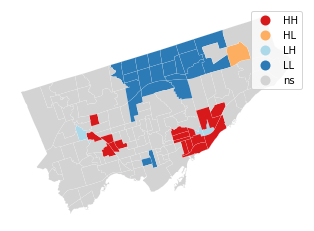

In [28]:
from splot.esda import lisa_cluster
splot.esda.lisa_cluster(lisa, nbrhd_simple)

Let's use what we learned before to plot the result of local autocorrelation.

Text(0.5, 1.0, 'Adult Asthma Percentages')

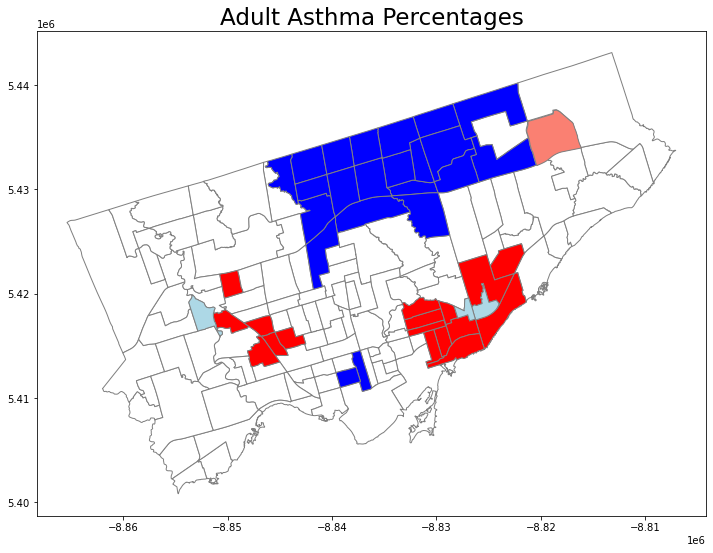

In [29]:
# Setup the figure and axis
fig, axes = plt.subplots(1,1, figsize=(12, 12))

# Plot insignificant clusters
ns = nbrhd_simple.loc[nbrhd_simple['significant']==False, 'geometry']
ns.plot(ax=axes, color='white', edgecolor='grey')

# Plot HH clusters
hh = nbrhd_simple.loc[(nbrhd_simple['quadrant']==1) & (nbrhd_simple['significant']==True), 'geometry']
hh.plot(ax=axes, color='red', edgecolor='grey')

# Plot LL clusters
ll = nbrhd_simple.loc[(nbrhd_simple['quadrant']==3) & (nbrhd_simple['significant']==True), 'geometry']
ll.plot(ax=axes, color='blue', edgecolor='grey')

# Plot LH clusters
lh = nbrhd_simple.loc[(nbrhd_simple['quadrant']==2) & (nbrhd_simple['significant']==True), 'geometry']
lh.plot(ax=axes, color='lightblue', edgecolor='grey')

# Plot HL clusters
hl = nbrhd_simple.loc[(nbrhd_simple['quadrant']==4) & (nbrhd_simple['significant']==True), 'geometry']
hl.plot(ax=axes, color='salmon', edgecolor='grey')

# Style and draw
axes.set_title("Adult Asthma Percentages", fontsize = 23)

**Finally, one more built in plot if you want!**

- It automatcially plot the local Moran's I scatter (the Moron's I plot but identify the significant neighbourhoods);

- the types and locations of the significant neighbourhoods;

- and the choropleth of the original variable in 5 quantiles (the asthema percentage)

(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

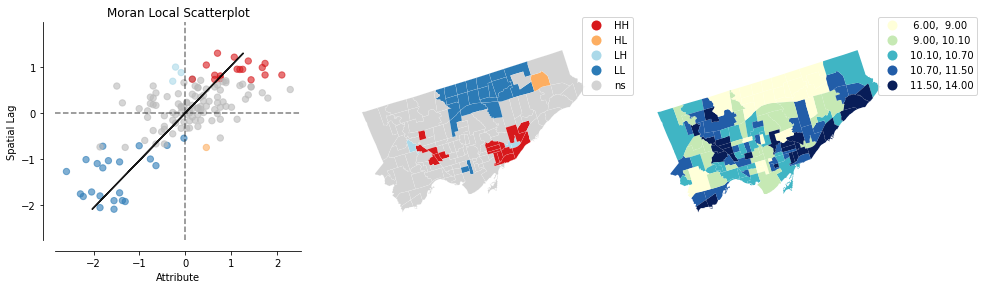

In [30]:
from splot.esda import plot_local_autocorrelation
splot.esda.plot_local_autocorrelation(lisa, nbrhd_simple, 'asthma_pct')

**Finally finally, let's look at what the random number col looks like...**

Even random distributions of data across space will sometime generate local clusters.

It's always good to consider the GLOBAL and LOCAL measures of spatial autocorrelation...

(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

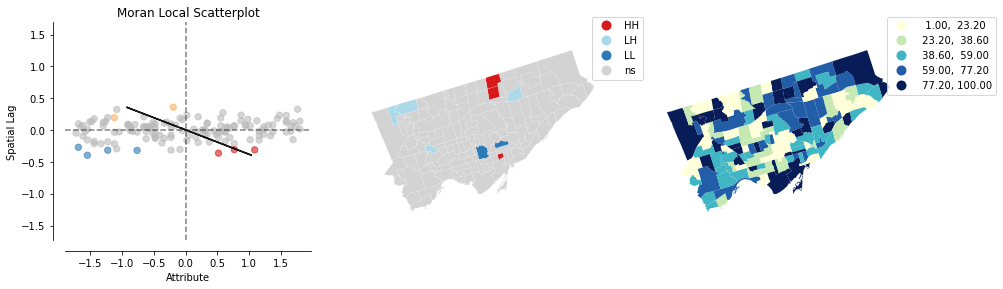

In [31]:
lisa_randNumCol = esda.Moran_Local(nbrhd_simple['randNumCol'], w)
splot.esda.plot_local_autocorrelation(lisa_randNumCol, nbrhd_simple, 'randNumCol')

### One more thing, let us do an exercise!

[exercise](Exercise/Cluster_analysis_exercise.ipynb)

[exercise_solusion](Exercise/Cluster_analysis_solusion.ipynb)

(Solusion will be available on Wednesday)